### For this project, I will be analyzing Lending Club loan data to model loan charge-offs. 
### Lending Club is a peer-to-peer lending platform in which investors lend money directly to people who are seeking unsecured loans.  
### They make their loan data public on a quarterly basis and their dataset contains many features.  I chose a handful that should predict whether a loan is charged off or not, i.e. a  loan is either fully paid off or "charged off' which means that the full amount of the loan is deemed uncollectable by Lending Club.  Dataset is from 2007-2011.
### Initial features:
### FICO scores, length of employment and the interest rate charged on the loan.
### All features were continuous variables.
### The outcome to be predicted was a simple binary answer of either "charged off" or  "fully paid.
### A logistic regression was used and the results were not particularly useful.  The AUC values were about .49 which meant that the features I chose were no better than chance at predicting whether someone would pay off their loan.
### So I went back and added more features.  Namely, annual income and amount borrowed were added to the logistic regression.
### Then, a random forest model incorporating all the same features was used.  Here are the results.

In [34]:
##importing libraries
import itertools
from sklearn import preprocessing
import re
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import sklearn.linear_model
import os
import math
import statsmodels.api as sm
import pylab as pl
from sklearn.metrics import roc_curve, auc

## reading in dataset

df = pd.read_csv('LoanStats3a_securev1.csv') #2007-11

df.columns.tolist()


['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'fico_range_low',
 'fico_range_high',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'last_fico_range_high',
 'last_fico_range_low',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'application_type',
 'annual_inc_joint',
 '

In [ ]:
df.

In [35]:
#Creating a new dataframe containing only relevant columns:
# Employment length, FICO, interest rate charged on the loan, loan amount, annual income of borrower.

df=df [['loan_amnt','annual_inc', 'loan_status','int_rate','fico_range_low','fico_range_high','emp_length', 'addr_state']]

df.head(10)

,loan_amnt,annual_inc,loan_status,int_rate,fico_range_low,fico_range_high,emp_length,addr_state
0,5000.0,24000.0,Fully Paid,10.65%,735.0,739.0,10+ years,AZ
1,2500.0,30000.0,Charged Off,15.27%,740.0,744.0,< 1 year,GA
2,2400.0,12252.0,Fully Paid,15.96%,735.0,739.0,10+ years,IL
3,10000.0,49200.0,Fully Paid,13.49%,690.0,694.0,10+ years,CA
4,3000.0,80000.0,Fully Paid,12.69%,695.0,699.0,1 year,OR
5,5000.0,36000.0,Fully Paid,7.90%,730.0,734.0,3 years,AZ
6,7000.0,47004.0,Fully Paid,15.96%,690.0,694.0,8 years,NC
7,3000.0,48000.0,Fully Paid,18.64%,660.0,664.0,9 years,CA
8,5600.0,40000.0,Charged Off,21.28%,675.0,679.0,4 years,CA
9,5375.0,15000.0,Charged Off,12.69%,725.0,729.0,< 1 year,TX


In [36]:
#int_rate was loaded as an object data type instead of float due to the '%' character.
#Let's strip out the percent sign and convert the column type.
df.int_rate = pd.Series(df.int_rate).str.replace('%', '').astype(float)
df.head()

,loan_amnt,annual_inc,loan_status,int_rate,fico_range_low,fico_range_high,emp_length,addr_state
0,5000.0,24000.0,Fully Paid,10.65,735.0,739.0,10+ years,AZ
1,2500.0,30000.0,Charged Off,15.27,740.0,744.0,< 1 year,GA
2,2400.0,12252.0,Fully Paid,15.96,735.0,739.0,10+ years,IL
3,10000.0,49200.0,Fully Paid,13.49,690.0,694.0,10+ years,CA
4,3000.0,80000.0,Fully Paid,12.69,695.0,699.0,1 year,OR


In [37]:
#Let's rename some columns for ease of use/readability.
df=df.rename(columns={'fico_range_low': 'fico_l', 'fico_range_high': 'fico_h', 'emp_length': 'length', 'int_rate': 'rate', 'addr_state': 'state', 'loan_status': 'status'})
df.tail(10)

,loan_amnt,annual_inc,status,rate,fico_l,fico_h,length,state
42532,6500.0,20000.0,Does not meet the credit policy. Status:Charge...,9.64,710.0,714.0,< 1 year,CT
42533,3500.0,180000.0,Does not meet the credit policy. Status:Fully ...,10.28,685.0,689.0,< 1 year,NY
42534,1000.0,12000.0,Does not meet the credit policy. Status:Fully ...,9.64,695.0,699.0,< 1 year,MA
42535,2525.0,110000.0,Does not meet the credit policy. Status:Fully ...,9.33,710.0,714.0,< 1 year,NY
42536,6500.0,NaN,Does not meet the credit policy. Status:Fully ...,8.38,740.0,744.0,< 1 year,NY
42537,5000.0,70000.0,Does not meet the credit policy. Status:Fully ...,7.75,770.0,774.0,10+ years,CT
42538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#Let's clean the loan status column by
#using a function to convert loan status 
# to a numerical value
# Charged off loans will be coded as 1;
# Fully paid loans coded as 0;
# Any other description of the loans will be coded as 2;

def status_func(x):
    if x == "Charged Off":
        return 1
    elif x == "Fully Paid":
        return 0
    else:
        return 2
   
df['status_1'] = df.apply(lambda x: status_func(x['status']), axis =1)
df.tail()

,loan_amnt,annual_inc,status,rate,fico_l,fico_h,length,state,status_1
42537,5000.0,70000.0,Does not meet the credit policy. Status:Fully ...,7.75,770.0,774.0,10+ years,CT,2
42538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
42539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
42540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
42541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [39]:
# We now have status_1 as our output variable but we must change the type to integer.
df['status_1'].astype(int)

0        0
1        1
2        0
3        0
4        0
5        0
6        0
7        0
8        1
9        1
10       0
11       0
12       1
13       0
14       1
15       0
16       0
17       0
18       0
19       0
20       0
21       1
22       0
23       0
24       1
25       0
26       1
27       1
28       0
29       0
        ..
42512    2
42513    2
42514    2
42515    2
42516    2
42517    2
42518    2
42519    2
42520    2
42521    2
42522    2
42523    2
42524    2
42525    2
42526    2
42527    2
42528    2
42529    2
42530    2
42531    2
42532    2
42533    2
42534    2
42535    2
42536    2
42537    2
42538    2
42539    2
42540    2
42541    2
Name: status_1, Length: 42542, dtype: int64

In [40]:
##We will further drop any NaN's
df.dropna(inplace= True) 
df.tail()

,loan_amnt,annual_inc,status,rate,fico_l,fico_h,length,state,status_1
42532,6500.0,20000.0,Does not meet the credit policy. Status:Charge...,9.64,710.0,714.0,< 1 year,CT,2
42533,3500.0,180000.0,Does not meet the credit policy. Status:Fully ...,10.28,685.0,689.0,< 1 year,NY,2
42534,1000.0,12000.0,Does not meet the credit policy. Status:Fully ...,9.64,695.0,699.0,< 1 year,MA,2
42535,2525.0,110000.0,Does not meet the credit policy. Status:Fully ...,9.33,710.0,714.0,< 1 year,NY,2
42537,5000.0,70000.0,Does not meet the credit policy. Status:Fully ...,7.75,770.0,774.0,10+ years,CT,2


In [41]:
## We will also drop any rows containing "does not meet credit policy"
## because the meaning is not clear and there are only a small number of 
##rows relative to the whole dataset
df=df[df.status_1 !=2]
df.tail()


,loan_amnt,annual_inc,status,rate,fico_l,fico_h,length,state,status_1
39781,2500.0,110000.0,Fully Paid,8.07,760.0,764.0,4 years,CO,0
39782,8500.0,18000.0,Fully Paid,10.28,690.0,694.0,3 years,NC,0
39783,5000.0,100000.0,Fully Paid,8.07,740.0,744.0,< 1 year,MA,0
39784,5000.0,200000.0,Fully Paid,7.43,810.0,814.0,< 1 year,MD,0
39785,7500.0,22000.0,Fully Paid,13.75,660.0,664.0,< 1 year,MA,0


In [42]:
##We lost 2756 out of a total of 42541 observations, or about .06% by dropping the Nans and "other
print 2756.00/42541


0.0647845607767


In [43]:
df['status_1'].value_counts()


0    34116
1     5670
Name: status_1, dtype: int64

In [44]:
#Let's further clean up our FICO scores columns. Because FICO scores are in a range, the average of the high and low will be
#generated. 

df['fico'] = df[['fico_l', 'fico_h']].mean(axis=1)

In [45]:
df.tail()

,loan_amnt,annual_inc,status,rate,fico_l,fico_h,length,state,status_1,fico
39781,2500.0,110000.0,Fully Paid,8.07,760.0,764.0,4 years,CO,0,762.0
39782,8500.0,18000.0,Fully Paid,10.28,690.0,694.0,3 years,NC,0,692.0
39783,5000.0,100000.0,Fully Paid,8.07,740.0,744.0,< 1 year,MA,0,742.0
39784,5000.0,200000.0,Fully Paid,7.43,810.0,814.0,< 1 year,MD,0,812.0
39785,7500.0,22000.0,Fully Paid,13.75,660.0,664.0,< 1 year,MA,0,662.0


In [46]:
## We will drop the fico_l and fico_h columns for readability
df=df.drop('fico_l', axis=1)
df=df.drop('fico_h', axis =1)

In [47]:
df.head()

,loan_amnt,annual_inc,status,rate,length,state,status_1,fico
0,5000.0,24000.0,Fully Paid,10.65,10+ years,AZ,0,737.0
1,2500.0,30000.0,Charged Off,15.27,< 1 year,GA,1,742.0
2,2400.0,12252.0,Fully Paid,15.96,10+ years,IL,0,737.0
3,10000.0,49200.0,Fully Paid,13.49,10+ years,CA,0,692.0
4,3000.0,80000.0,Fully Paid,12.69,1 year,OR,0,697.0


In [48]:
#Finally, we will convert the values in the employment length column
#to integers 
df['length'].value_counts()

10+ years    8899
< 1 year     4590
2 years      4394
3 years      4098
4 years      3444
5 years      3286
1 year       3247
6 years      2231
7 years      1775
8 years      1485
9 years      1259
n/a          1078
Name: length, dtype: int64

In [49]:
#Convert employment length from object to an integer
df.replace('n/a', np.nan,inplace=True)
df.length.fillna(value=0,inplace=True)
df['length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df['length'] = df['length'].astype(int)

In [50]:
df.info

<bound method DataFrame.info of        loan_amnt  annual_inc       status   rate  length state  status_1  \
0         5000.0    24000.00   Fully Paid  10.65      10    AZ         0   
1         2500.0    30000.00  Charged Off  15.27       1    GA         1   
2         2400.0    12252.00   Fully Paid  15.96      10    IL         0   
3        10000.0    49200.00   Fully Paid  13.49      10    CA         0   
4         3000.0    80000.00   Fully Paid  12.69       1    OR         0   
5         5000.0    36000.00   Fully Paid   7.90       3    AZ         0   
6         7000.0    47004.00   Fully Paid  15.96       8    NC         0   
7         3000.0    48000.00   Fully Paid  18.64       9    CA         0   
8         5600.0    40000.00  Charged Off  21.28       4    CA         1   
9         5375.0    15000.00  Charged Off  12.69       1    TX         1   
10        6500.0    72000.00   Fully Paid  14.65       5    AZ         0   
11       12000.0    75000.00   Fully Paid  12.69      10

In [51]:
df["length"].value_counts()

10    8899
1     7837
2     4394
3     4098
4     3444
5     3286
6     2231
7     1775
8     1485
9     1259
0     1078
Name: length, dtype: int64

In [52]:
df.head()

,loan_amnt,annual_inc,status,rate,length,state,status_1,fico
0,5000.0,24000.0,Fully Paid,10.65,10,AZ,0,737.0
1,2500.0,30000.0,Charged Off,15.27,1,GA,1,742.0
2,2400.0,12252.0,Fully Paid,15.96,10,IL,0,737.0
3,10000.0,49200.0,Fully Paid,13.49,10,CA,0,692.0
4,3000.0,80000.0,Fully Paid,12.69,1,OR,0,697.0


In [53]:
df.describe()

,loan_amnt,annual_inc,rate,length,status_1,fico
count,39786.000000,3.978600e+04,39786.000000,39786.000000,39786.000000,39786.000000
mean,11231.360277,6.897907e+04,12.027873,4.954934,0.142512,716.997989
std,7464.542832,6.376263e+04,3.727466,3.462426,0.349579,35.840682
min,500.000000,4.000000e+03,5.420000,0.000000,0.000000,627.000000
25%,5500.000000,4.050000e+04,9.250000,2.000000,0.000000,687.000000
50%,10000.000000,5.900000e+04,11.860000,4.000000,0.000000,712.000000
75%,15000.000000,8.234250e+04,14.590000,9.000000,0.000000,742.000000
max,35000.000000,6.000000e+06,24.590000,10.000000,1.000000,827.000000


## Average values:
### Loan amount: 11,231
### Annual income: 69,000
### Interest rate: 12%
### Length of employment: 5 years
### FICO: 716

### Now our dataset is ready to go! It contains only the columns we want to incorporate into our model.  Before we do any analysis, let's plot some data. 

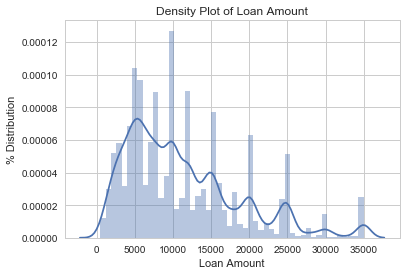

In [54]:
# Density Distribution of Loan Amount
sns.set_style("whitegrid")
ax=sns.distplot(df.loan_amnt)
ax.set(xlabel='Loan Amount', 
       ylabel='% Distribution',title='Density Plot of Loan Amount')

plt.legend();

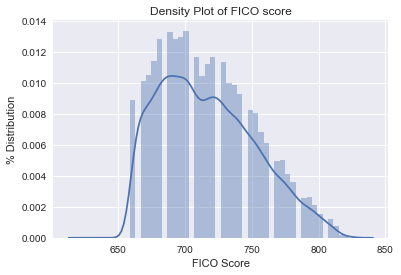

In [55]:
# Density Distribution of FICO scores
sns.set_style("darkgrid")
ax=sns.distplot(df.fico)
ax.set(xlabel='FICO Score', 
       ylabel='% Distribution',title='Density Plot of FICO score')

plt.legend();

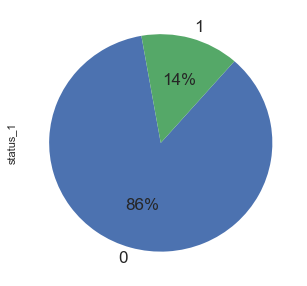

In [56]:
#Distribution of our target variable.  A pie chart showing the ratio of loans fully paid and charged off
##to the total number of loans.
plt.figure(figsize=(5,5))
df['status_1'].value_counts().plot(kind = 'pie',autopct='%.0f%%', startangle=100, fontsize=17)
plt.show()

### Ratio of loans fully paid was 86% and charged off was 14%. 


            loan_amnt  annual_inc      fico      rate    length
loan_amnt    1.000000    0.271340  0.116572  0.310481  0.162359
annual_inc   0.271340    1.000000  0.049220  0.053485  0.122358
fico         0.116572    0.049220  1.000000 -0.702786  0.065394
rate         0.310481    0.053485 -0.702786  1.000000  0.017656
length       0.162359    0.122358  0.065394  0.017656  1.000000
Axes(0.125,0.125;0.62x0.755)


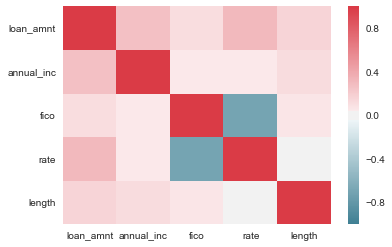

In [57]:
##let's check for multicolinnearity via heat map


##Heat map check for multicollinearity
cmap = sns.diverging_palette(220, 10, as_cmap=True)

correlations = df[['loan_amnt', 'annual_inc', 'fico', 'rate', 'length']].corr()
print correlations
print sns.heatmap(correlations, cmap=cmap)



### There doesn't appear to be any significant mulitcolinnearity. 

In [58]:
##let's run our logistic regression

X = df[['rate', 'length', 'fico', 'loan_amnt','annual_inc']]
X = sm.add_constant(X)
y = df['status_1']

lm = sm.Logit(y, X)
result = lm.fit()

result.summary()

Optimization terminated successfully.
         Current function value: 0.386996
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               status_1   No. Observations:                39786
Model:                          Logit   Df Residuals:                    39780
Method:                           MLE   Df Model:                            5
Date:                Wed, 02 Aug 2017   Pseudo R-squ.:                 0.05495
Time:                        12:33:28   Log-Likelihood:                -15397.
converged:                       True   LL-Null:                       -16292.
                                        LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6154      0.541     -8.534      0.000      -5.675      -3.555
rate           0.1648      0.007     25.208      0.000       0.152       0.178
length         0.0095      0.004      2.168      0.030       0.001       0.018
fico           0.0015      0.001      2.133      0.033       0.000       0.003
loan_amnt   4.629e-06   2.54e-06      1.823      0.068   -3.49e-07    9.61e-06
annual_inc -6.463e-06   4.68e-07    -13.814      0.000   -7.38e-06   -5.55e-06
==============================================================================
"""

In [59]:
df.status_1.mean()


0.14251244156235862

In [60]:
print np.exp(result.params)

#Let's calculate accuracy:
predicted = result.predict(X)
threshold = 0.5
predicted_classes = (predicted > threshold).astype(int)
from sklearn.metrics import accuracy_score
print 'Accuracy score'
accuracy_score(y, predicted_classes)

const         0.009898
rate          1.179188
length        1.009519
fico          1.001459
loan_amnt     1.000005
annual_inc    0.999994
dtype: float64
Accuracy score


0.85751269290705279

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

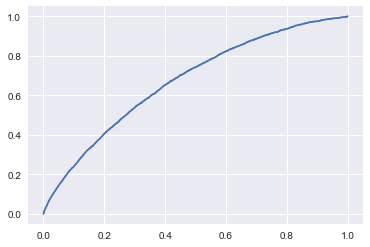

In [62]:
plt.plot(roc_curve(df[['status_1']], predicted)[0], roc_curve(df[['status_1']], predicted)[1])

In [63]:
#Here's the roc score: 
roc_auc_score(df['status_1'], predicted_classes)

0.50045582112940534

### We can see that we were not able to create a predictive model using logistic regression.
### Although we were able to get a high accuracy score of .85 (TP + TN/Total Population), the AUC score of .50 indicates that our variables are no better than chance at predicting loan charge-offs.   Further,  our R-squared value was extremely low and the coefficients of each of our features was very low and for annual income, the coefficient was actually slightly negative.  
### Let's try a Random Forest model. 



In [64]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)
    
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [65]:
features = X.columns
feature_importances = model.feature_importances_

features_df = pd.DataFrame({'Features': features, 'Importance Score': feature_importances})
features_df.sort_values('Importance Score', inplace=True, ascending=False)

features_df.head()

,Features,Importance Score
5,annual_inc,0.272628
1,rate,0.260449
4,loan_amnt,0.216533
3,fico,0.139834
2,length,0.110557


### The importance score of each variable is relatively low.  

## We'll evaluate the Random Forest model using cross-validation and see if that improves predictive performance.

In [66]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(model, X, y, scoring='roc_auc')
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))

for n_trees in range(1, 10, 10):
    model = RandomForestClassifier(n_estimators = n_trees)
    scores = cross_val_score(model, X, y, scoring='roc_auc')
    print('n trees: {}, CV AUC {}, Average AUC {}'.format(n_trees, scores, scores.mean()))

CV AUC [ 0.63311729  0.6078643   0.57689966], Average AUC 0.605960414546
n trees: 1, CV AUC [ 0.53183781  0.53396805  0.52217923], Average AUC 0.529328362121


### The highest AUC we were able to achieve was approximately .65 and the highest average AUC was .63.
### Thus, we could say that we still do not have the apppropriate features in this model to predict loan charge-offs.

## Summary: Annual income, FICO score, length of employment, rate charged on loan and amount borrowed should have intuitively predicted which loans would be charged off or fully paid.  
    The more one makes, the easier it is to pay off debt or the better the credit score, the better the credit risk.
    In considering why the model failed, it seems likely that I did not have enough features     despite low multicolinearity among them.
    
    There must be more subtle factors at work.  For future work, I would incorporate as many features as possible and then perhaps let the machine learning algo pick the ones that have some predictive power.
    
    In studying some other people's work, this seems like the best choice. 
    
    Combining the Lending Club dataset with some external data such as macroeconomic date would also be an interesting path. The loan data was microeconomic in scope and comparing it to broader trends could yield some interesting insight.  
    
    There are several aspects of this project that I really enjoyed.  
    
    Earlier in the course, I kept saying to myself, you could just do this in MS Excel and not have to write much code.  Now, I see how wrong I was.  Try simply loading this Lending Club dataset into Excel and I'll see you in about five minutes.   After learning a bit of pandas, I have come to see the power of dataframes and python.  When dealing with data, you need the best tools.  
    
    Unexpectedly, cleaning the dataset and getting it into a form that I can work with was immensely satisfying.  The preprocessing code was a challenge at first, but with each step, from choosing the columns to changing the object type, I could see the raw data come to life and it became my own. 
    
    If data is Mount Everest, scraping off and polishing a boulder from its base is rewarding, no matter how small.  Much like your first love, what is done after polishing the stone can yield both frustration and elation. I will continue my climb. 